# Import Necessary Libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# Importing the Dataset

## Read and Explore the Data

In [ ]:
#Import the data set
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/Content-based RS/'
df = pd.read_csv(path + 'Reviews.csv')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# Dropping the columns
df = df.drop(['Id', 'ProfileName','Time','HelpfulnessNumerator','HelpfulnessDenominator','Text','Summary'], axis = 1)


In [ ]:
# see few rows of the imported dataset
df.tail()

,ProductId,UserId,Score
568449,B001EO7N10,A28KG5XORO54AY,5
568450,B003S1WTCU,A3I8AFVPEE8KI5,2
568451,B004I613EE,A121AA1GQV751Z,5
568452,B004I613EE,A3IBEVCTXKNOH,5
568453,B001LR2CU2,A3LGQPJCZVL9UC,5


In [ ]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  568454
No of columns:  3


In [ ]:
#Check Data types
df.dtypes

ProductId    object
UserId       object
Score         int64
dtype: object

In [ ]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 ProductId    0
UserId       0
Score        0
dtype: int64


### There are no missing values with total records 568454


In [ ]:
# Summary statistics of 'rating' variable
df[['Score']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Score,568454.0,4.183199,1.310436,1.0,4.0,5.0,5.0,5.0


In [ ]:
# find minimum and maximum ratings

def find_min_max_rating():
    print('The minimum rating is: %d' %(df['Score'].min()))
    print('The maximum rating is: %d' %(df['Score'].max()))

find_min_max_rating()

The minimum rating is: 1
The maximum rating is: 5


### Ratings are on scale of 1 - 5


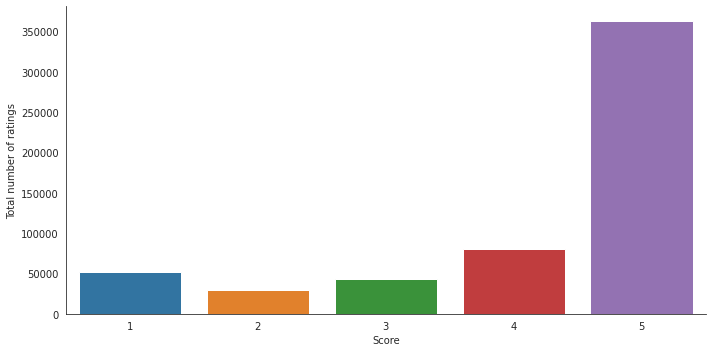

In [ ]:
# Check the distribution of ratings
with sns.axes_style('white'):
    g = sns.factorplot("Score", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['UserId'].nunique())
print('Number of unique ITEMS in Raw data = ', df['ProductId'].nunique())

Number of unique USERS in Raw data =  256059
Number of unique ITEMS in Raw data =  74258


### Take subset of dataset to make it less sparse/more dense. ( For example, keep the users only who has given 50 or more number of ratings )

In [ ]:
# Top 10 users based on rating
most_rated = df.groupby('UserId').size().sort_values(ascending=False)[:10]
most_rated

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
A1TMAVN4CEM8U8    204
A2MUGFV2TDQ47K    201
A3TVZM3ZIXG8YW    199
A3PJZ8TU8FDQ1K    178
AQQLWCMRNDFGI     176
dtype: int64

### Data model preparation as per requirement on number of minimum ratings


In [ ]:
counts = df['UserId'].value_counts()
df_final = df[df['UserId'].isin(counts[counts >= 50].index)]

In [ ]:
df_final.head()

,ProductId,UserId,Score
14,B001GVISJM,A2MUGFV2TDQ47K,5
44,B001EO5QW8,A2G7B7FKP2O2PU,5
46,B001EO5QW8,AQLL2R1PPR46X,5
109,B001REEG6C,AY12DBB0U420B,5
141,B001GVISJW,A2YIO225BTKVPU,4


In [ ]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['UserId'].nunique())
print('Number of unique ITEMS in final data = ', df_final['ProductId'].nunique())

Number of users who have rated 50 or more items = 22941
Number of unique USERS in final data =  267
Number of unique ITEMS in final data =  11313


#### df_final has users  who have rated 50 or more items

#### Calculate the density of the rating matrix

In [ ]:

final_ratings_matrix = pd.pivot_table(df_final,index=['UserId'], columns = 'ProductId', values = "Score")
final_ratings_matrix.fillna(0,inplace=True)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (267, 11313)
given_num_of_ratings =  20829
possible_num_of_ratings =  3020571
density: 0.69%


In [ ]:
final_ratings_matrix.tail()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B000084346,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJR,B000084EJS,B000084EJT,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084ETY,B000084EZ4,B000087BJ3,...,B0094UVRXG,B00954NY46,B00954NYVY,B0095BOA2E,B0095XTFO0,B0096EZHM2,B0096PKSAC,B0096QXV5A,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B0098WV8F2,B009AFJ3I6,B009AFJ548,B009B87RWG,B009B87SAC,B009B87TKG,B009DS6IF6,B009E7YC54,B009EQQL5Y,B009EXL6IO,B009GHI5Q4,B009GHI6I6,B009HXB2JO,B009IQLAQK,B009IXNU7U,B009K2BBQG,B009K2BBT8,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AY1EF0GOH80EK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYB4ELCS5AM8P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYGJ96W5KQMUJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYOMAHLWRQHUG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZV26LP92E6WU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

UserId,A100WO06OQR8BQ,A106ZCP7RSXMRU,A1080SE9X3ECK0,A10G136JEISLVR,A11ED8O95W2103,A11OTLEDSW8ZXD,A12ENBT314RFXR,A132ETQPMHQ585,A13GZCHAMKWYBT,A13HRSMJ5TOWEZ,A13K3ZLWAWN1EI,A13MKSASQ6YWL7,A13WOT3RSXKRD5,A16AXQ11SZA8SQ,A16KK3YHCWE29C,A16WPA6JV83YXT,A175N19FS2B4J,A17GK9E70O7Y9R,A17HMM1M7T9PJ1,A17V9XL4CWTQ6G,A18L1CVUIQRE9L,A19123D9G66E0O,A19SDJ2TSSL8HI,A1A1BM6N28X9J0,A1AEPMPA12GUJ7,A1AEQZM99LO9VA,A1B05INWIDZ74O,A1B6O7SAIYG2N0,A1BD342U8BF3UC,A1DH3QDZX8Z7GO,A1F7YU6O5RU432,A1FP5ZLSKR07SU,A1G60ANYI0HMEU,A1GQAKL9CGQLP1,A1GYEGLX3P2Y7P,A1H7Y5XKPGT0OS,A1HOXKR7OKJ1X1,A1HRYC60VTMYC0,A1I85Y08VRZ32Q,A1IH42TUIZ2XJL,...,AEC90GPFKLAAW,AEL6CQNQXONBX,AF3BYMPWKWO8F,AI0NMYA3LKXW1,AIEEK7AHXKZCC,AIQDUKFB4X38M,AJB5P7GVR0MT8,AJCK6OKNWGIYG,AJD41FBJD9010,AJQDIT55SZ3ZX,AK7CAW3N1XZV6,AK8LOFYRZJJW0,AKJHHD5VEH7VG,AKMEY1BSHSDG7,AKZKG2Z7CNV27,ALDAF4VVLFRHP,ALL9XFM0Q1N4E,ALSAOZ1V546VT,AMPGRXQMO89X9,AMQ1MEG334SAP,AMRMK86X3PKXD,ANCOMAI0I7LVG,APP8XWYYV4PAA,AQ52JX9ES6XYY,AQ6AGWKWMTY8H,AQLL2R1PPR46X,AQQLWCMRNDFGI,AR7TAEEUDHMUB,ARYSDAZNRXN6G,AT9U5ZE5OO84C,ATJN4KEHJBOC8,AVFA1JB08RG8G,AWKZAUC0D8DYL,AXO4PQU0XG3TG,AY12DBB0U420B,AY1EF0GOH80EK,AYB4ELCS5AM8P,AYGJ96W5KQMUJ,AYOMAHLWRQHUG,AZV26LP92E6WU
ProductId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7310172001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7310172101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7800648702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004CI84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
B00004CXX9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


### Split the data randomly into train and test dataset. ( For example split it in 70/30 ratio)

In [ ]:
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)

print(train_data.head(5))

         ProductId          UserId  Score
399863  B002IEVJRY  A1N5FSCYN4796F      3
20262   B001BDDTB2  A1Q7A78VSQ5GQ4      5
139611  B001BCXTGS  A2PNOU7NXB1JE4      3
455504  B005HG9ERW  A2SZLNSI5KOQJT      3
512008  B0028PDER6   ALSAOZ1V546VT      5


In [ ]:
def shape():
    print("Test data shape: ", test_data.shape)
    print("Train data shape: ", train_data.shape)
shape()

Test data shape:  (6883, 3)
Train data shape:  (16058, 3)


# Build Popularity Recommender model. (Non-personalised)

In [ ]:
#Count of user_id for each unique product as recommendation score
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'score'},inplace=True)
train_data_grouped.head()

,ProductId,score
0,7310172001,5
1,7310172101,5
2,7800648702,1
3,B00004CI84,2
4,B00004CXX9,3


In [ ]:
#Sort the products on recommendation score
train_data_sort = train_data_grouped.sort_values(['score', 'ProductId'], ascending = [0,1])

#Generate a recommendation rank based upon score
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')

#Get the top 5 recommendations
popularity_recommendations = train_data_sort.head(5)
popularity_recommendations

,ProductId,score,Rank
5621,B002IEZJMA,48,1.0
8130,B006MONQMC,42,2.0
5620,B002IEVJRY,41,3.0
6779,B0041NYV8E,39,4.0
7876,B005HG9ET0,39,5.0


In [ ]:
# Use popularity based recommender model to make predictions
def recommend(user_id):
    user_recommendations = popularity_recommendations

    #Add user_id column for which the recommendations are being generated
    user_recommendations['UserId'] = user_id

    #Bring user_id column to the front
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]

    return user_recommendations

In [ ]:
find_recom = [15,121,200]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))
    print("\n")

Here is the recommendation for the userId: 15

      UserId   ProductId  score  Rank
5621      15  B002IEZJMA     48   1.0
8130      15  B006MONQMC     42   2.0
5620      15  B002IEVJRY     41   3.0
6779      15  B0041NYV8E     39   4.0
7876      15  B005HG9ET0     39   5.0


Here is the recommendation for the userId: 121

      UserId   ProductId  score  Rank
5621     121  B002IEZJMA     48   1.0
8130     121  B006MONQMC     42   2.0
5620     121  B002IEVJRY     41   3.0
6779     121  B0041NYV8E     39   4.0
7876     121  B005HG9ET0     39   5.0


Here is the recommendation for the userId: 200

      UserId   ProductId  score  Rank
5621     200  B002IEZJMA     48   1.0
8130     200  B006MONQMC     42   2.0
5620     200  B002IEVJRY     41   3.0
6779     200  B0041NYV8E     39   4.0
7876     200  B005HG9ET0     39   5.0




In [ ]:
print('Since this is a popularity-based recommender model, recommendations remain the same for all users')
print('\nWe predict the products based on the popularity. It is not personalized to particular user')

Since this is a popularity-based recommender model, recommendations remain the same for all users

We predict the products based on the popularity. It is not personalized to particular user


# Build Collaborative Filtering model.

#### Model-based Collaborative Filtering: Singular Value Decomposition

In [ ]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail()

,index,ProductId,UserId,Score
22936,275741,B001M23WVY,AY1EF0GOH80EK,2
22937,281102,B002R8SLUY,A16AXQ11SZA8SQ,5
22938,205589,B00473PVVO,A281NPSIMI1C2R,5
22939,303238,B0002DGRZC,AJD41FBJD9010,5
22940,36703,B000EEWZD2,A2M9D9BDHONV3Y,3


In [ ]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item'
pivot_df = pd.pivot_table(df_CF,index=['UserId'], columns = 'ProductId', values = "Score")
pivot_df.fillna(0,inplace=True)
print(pivot_df.shape)
pivot_df.head()

(267, 11313)


ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B000084346,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJR,B000084EJS,B000084EJT,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084ETY,B000084EZ4,B000087BJ3,...,B0094UVRXG,B00954NY46,B00954NYVY,B0095BOA2E,B0095XTFO0,B0096EZHM2,B0096PKSAC,B0096QXV5A,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B0098WV8F2,B009AFJ3I6,B009AFJ548,B009B87RWG,B009B87SAC,B009B87TKG,B009DS6IF6,B009E7YC54,B009EQQL5Y,B009EXL6IO,B009GHI5Q4,B009GHI6I6,B009HXB2JO,B009IQLAQK,B009IXNU7U,B009K2BBQG,B009K2BBT8,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B000084346,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJR,B000084EJS,B000084EJT,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084ETY,B000084EZ4,B000087BJ3,...,B00954NY46,B00954NYVY,B0095BOA2E,B0095XTFO0,B0096EZHM2,B0096PKSAC,B0096QXV5A,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B0098WV8F2,B009AFJ3I6,B009AFJ548,B009B87RWG,B009B87SAC,B009B87TKG,B009DS6IF6,B009E7YC54,B009EQQL5Y,B009EXL6IO,B009GHI5Q4,B009GHI6I6,B009HXB2JO,B009IQLAQK,B009IXNU7U,B009K2BBQG,B009K2BBT8,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4,user_index
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B000084346,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJR,B000084EJS,B000084EJT,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084ETY,B000084EZ4,B000087BJ3,...,B0094UVRXG,B00954NY46,B00954NYVY,B0095BOA2E,B0095XTFO0,B0096EZHM2,B0096PKSAC,B0096QXV5A,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B0098WV8F2,B009AFJ3I6,B009AFJ548,B009B87RWG,B009B87SAC,B009B87TKG,B009DS6IF6,B009E7YC54,B009EQQL5Y,B009EXL6IO,B009GHI5Q4,B009GHI6I6,B009HXB2JO,B009IQLAQK,B009IXNU7U,B009K2BBQG,B009K2BBT8,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SVD method
#### SVD is best to apply on a large sparse matrix

In [ ]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 50)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

### Note that for sparse matrices, you can use the sparse.linalg.svds() function to perform the decomposition.
SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and Latent Semantic Indexing (LSI), used in document retrieval and word similarity in Text mining

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B000084346,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJR,B000084EJS,B000084EJT,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084ETY,B000084EZ4,B000087BJ3,...,B0094UVRXG,B00954NY46,B00954NYVY,B0095BOA2E,B0095XTFO0,B0096EZHM2,B0096PKSAC,B0096QXV5A,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B0098WV8F2,B009AFJ3I6,B009AFJ548,B009B87RWG,B009B87SAC,B009B87TKG,B009DS6IF6,B009E7YC54,B009EQQL5Y,B009EXL6IO,B009GHI5Q4,B009GHI6I6,B009HXB2JO,B009IQLAQK,B009IXNU7U,B009K2BBQG,B009K2BBT8,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
0,-0.023781,-0.023781,-0.002054,0.104898,0.104898,0.024303,0.107537,0.104898,-0.020275,-0.059207,-0.021307,-0.074008,0.128332,-0.155812,-0.155812,-0.222207,-0.075173,0.066329,0.066329,0.066329,0.066329,0.066329,0.049747,0.082911,0.082911,0.066329,0.049747,0.016582,0.066329,0.066329,0.082911,0.033164,0.082911,0.049747,-0.074008,-0.007679,0.047354,-0.106403,-0.076416,0.090633,...,0.043468,0.042253,0.042253,0.050400,0.005286,0.211324,0.005832,-0.005215,-3.862578e-04,0.001293,0.016533,0.082911,0.001253,-0.005847,0.110259,0.047276,-0.222207,0.049459,0.018648,-0.007071,0.000494,0.082911,-0.222207,-0.004502,0.031882,-0.082467,-0.084344,-0.017392,-0.017392,0.046674,0.046674,0.046674,0.016852,0.046674,-0.017740,0.097006,0.083491,0.076254,-0.057970,0.057460
1,-0.007905,-0.007905,-0.003851,-0.008111,-0.008111,-0.000537,-0.010274,-0.008111,-0.000594,0.032172,-0.003988,0.040215,-0.193969,-0.086633,-0.086633,-0.068108,0.038713,-0.012477,-0.012477,-0.012477,-0.012477,-0.012477,-0.009358,-0.015597,-0.015597,-0.012477,-0.009358,-0.003119,-0.012477,-0.012477,-0.015597,-0.006239,-0.015597,-0.009358,0.040215,0.027738,0.008498,-0.035995,-0.036686,0.027240,...,-0.019711,0.001198,0.001198,0.003986,0.010498,-0.053990,-0.000330,-0.000370,2.181314e-04,0.001332,-0.016475,-0.015597,-0.005394,-0.024105,0.015573,-0.036594,-0.068108,0.001104,-0.010987,-0.025898,0.009546,-0.015597,-0.068108,-0.001626,0.001404,0.012722,0.078770,0.019263,0.019263,-0.028196,-0.028196,-0.028196,0.040836,-0.028196,0.002385,0.027653,0.566969,-0.027474,0.009181,0.000949
2,0.002045,0.002045,0.021680,0.053874,0.053874,-0.005837,-0.008159,0.053874,-0.046556,0.006265,0.063816,0.007832,-0.175811,-0.009471,-0.009471,-0.075006,0.047786,-0.011107,-0.011107,-0.011107,-0.011107,-0.011107,-0.008330,-0.013884,-0.013884,-0.011107,-0.008330,-0.002777,-0.011107,-0.011107,-0.013884,-0.005554,-0.013884,-0.008330,0.007832,-0.003275,0.009264,-0.043557,-0.001204,-0.096438,...,0.051325,-0.019441,-0.019441,0.009222,0.004986,0.085391,0.002931,-0.031614,2.516574e-03,-0.000436,-0.023401,-0.013884,0.008848,-0.031491,-0.007481,-0.005930,-0.075006,0.008199,-0.012763,0.007934,-0.004969,-0.013884,-0.075006,-0.001364,0.047945,0.034932,0.117184,0.037284,0.037284,-0.072355,-0.072355,-0.072355,0.038650,-0.072355,-0.047259,0.014912,-0.038054,0.122540,0.068785,0.021741
3,0.000029,0.000029,-0.000028,0.000039,0.000039,-0.000002,-0.000218,0.000039,0.000419,0.000130,-0.000078,0.000162,-0.000083,-0.000029,-0.000029,0.000189,-0.000194,0.000017,0.000017,0.000017,0.000017,0.000017,0.000013,0.000021,0.000021,0.000017,0.000013,0.000004,0.000017,0.000017,0.000021,0.000008,0.000021,0.000013,0.000162,0.000179,-0.000055,0.000099,-0.000046,-0.000042,...,-0.000034,0.000015,0.000015,0.000015,-0.000004,-0.000151,0.000001,-0.000096,3.411663e-07,-0.000004,-0.000047,0.000021,-0.000035,0.000002,-0.000039,-0.000004,0.000189,0.000009,-0.000041,-0.000103,-0.000010,0.000021,0.000189,0.000003,0.000006,-0.000350,-0.000170,0.000037,0.000037,0.000046,0.000046,0.000046,0.000019,0.000046,0.000292,-0.000033,0.000224,-0.000047,0.000142,0.000023
4,0.006935,0.006935,-0.000392

In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):

    user_idx = userID-1 # index starts at 0

    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']

    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 121
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 121):

                   user_ratings  user_predictions
Recommended Items                                
B004E4EBMG                  0.0          1.553272
B004JGQ15E                  0.0          0.972833
B0061IUIDY                  0.0          0.923977
B0041NYV8E                  0.0          0.901132
B001LG940E                  0.0          0.893659


# Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

#### Evaluation of Model-based Collaborative Filtering (SVD)


In [ ]:
# Actual ratings given by the users
final_ratings_matrix.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B000084346,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJR,B000084EJS,B000084EJT,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084ETY,B000084EZ4,B000087BJ3,...,B0094UVRXG,B00954NY46,B00954NYVY,B0095BOA2E,B0095XTFO0,B0096EZHM2,B0096PKSAC,B0096QXV5A,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B0098WV8F2,B009AFJ3I6,B009AFJ548,B009B87RWG,B009B87SAC,B009B87TKG,B009DS6IF6,B009E7YC54,B009EQQL5Y,B009EXL6IO,B009GHI5Q4,B009GHI6I6,B009HXB2JO,B009IQLAQK,B009IXNU7U,B009K2BBQG,B009K2BBT8,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

ProductId
7310172001    0.037453
7310172101    0.037453
7800648702    0.018727
B00004CI84    0.044944
B00004CXX9    0.044944
dtype: float64

In [ ]:
# Predicted ratings
preds_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B000084346,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJR,B000084EJS,B000084EJT,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084ETY,B000084EZ4,B000087BJ3,...,B0094UVRXG,B00954NY46,B00954NYVY,B0095BOA2E,B0095XTFO0,B0096EZHM2,B0096PKSAC,B0096QXV5A,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B0098WV8F2,B009AFJ3I6,B009AFJ548,B009B87RWG,B009B87SAC,B009B87TKG,B009DS6IF6,B009E7YC54,B009EQQL5Y,B009EXL6IO,B009GHI5Q4,B009GHI6I6,B009HXB2JO,B009IQLAQK,B009IXNU7U,B009K2BBQG,B009K2BBT8,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
0,-0.023781,-0.023781,-0.002054,0.104898,0.104898,0.024303,0.107537,0.104898,-0.020275,-0.059207,-0.021307,-0.074008,0.128332,-0.155812,-0.155812,-0.222207,-0.075173,0.066329,0.066329,0.066329,0.066329,0.066329,0.049747,0.082911,0.082911,0.066329,0.049747,0.016582,0.066329,0.066329,0.082911,0.033164,0.082911,0.049747,-0.074008,-0.007679,0.047354,-0.106403,-0.076416,0.090633,...,0.043468,0.042253,0.042253,0.050400,0.005286,0.211324,0.005832,-0.005215,-3.862578e-04,0.001293,0.016533,0.082911,0.001253,-0.005847,0.110259,0.047276,-0.222207,0.049459,0.018648,-0.007071,0.000494,0.082911,-0.222207,-0.004502,0.031882,-0.082467,-0.084344,-0.017392,-0.017392,0.046674,0.046674,0.046674,0.016852,0.046674,-0.017740,0.097006,0.083491,0.076254,-0.057970,0.057460
1,-0.007905,-0.007905,-0.003851,-0.008111,-0.008111,-0.000537,-0.010274,-0.008111,-0.000594,0.032172,-0.003988,0.040215,-0.193969,-0.086633,-0.086633,-0.068108,0.038713,-0.012477,-0.012477,-0.012477,-0.012477,-0.012477,-0.009358,-0.015597,-0.015597,-0.012477,-0.009358,-0.003119,-0.012477,-0.012477,-0.015597,-0.006239,-0.015597,-0.009358,0.040215,0.027738,0.008498,-0.035995,-0.036686,0.027240,...,-0.019711,0.001198,0.001198,0.003986,0.010498,-0.053990,-0.000330,-0.000370,2.181314e-04,0.001332,-0.016475,-0.015597,-0.005394,-0.024105,0.015573,-0.036594,-0.068108,0.001104,-0.010987,-0.025898,0.009546,-0.015597,-0.068108,-0.001626,0.001404,0.012722,0.078770,0.019263,0.019263,-0.028196,-0.028196,-0.028196,0.040836,-0.028196,0.002385,0.027653,0.566969,-0.027474,0.009181,0.000949
2,0.002045,0.002045,0.021680,0.053874,0.053874,-0.005837,-0.008159,0.053874,-0.046556,0.006265,0.063816,0.007832,-0.175811,-0.009471,-0.009471,-0.075006,0.047786,-0.011107,-0.011107,-0.011107,-0.011107,-0.011107,-0.008330,-0.013884,-0.013884,-0.011107,-0.008330,-0.002777,-0.011107,-0.011107,-0.013884,-0.005554,-0.013884,-0.008330,0.007832,-0.003275,0.009264,-0.043557,-0.001204,-0.096438,...,0.051325,-0.019441,-0.019441,0.009222,0.004986,0.085391,0.002931,-0.031614,2.516574e-03,-0.000436,-0.023401,-0.013884,0.008848,-0.031491,-0.007481,-0.005930,-0.075006,0.008199,-0.012763,0.007934,-0.004969,-0.013884,-0.075006,-0.001364,0.047945,0.034932,0.117184,0.037284,0.037284,-0.072355,-0.072355,-0.072355,0.038650,-0.072355,-0.047259,0.014912,-0.038054,0.122540,0.068785,0.021741
3,0.000029,0.000029,-0.000028,0.000039,0.000039,-0.000002,-0.000218,0.000039,0.000419,0.000130,-0.000078,0.000162,-0.000083,-0.000029,-0.000029,0.000189,-0.000194,0.000017,0.000017,0.000017,0.000017,0.000017,0.000013,0.000021,0.000021,0.000017,0.000013,0.000004,0.000017,0.000017,0.000021,0.000008,0.000021,0.000013,0.000162,0.000179,-0.000055,0.000099,-0.000046,-0.000042,...,-0.000034,0.000015,0.000015,0.000015,-0.000004,-0.000151,0.000001,-0.000096,3.411663e-07,-0.000004,-0.000047,0.000021,-0.000035,0.000002,-0.000039,-0.000004,0.000189,0.000009,-0.000041,-0.000103,-0.000010,0.000021,0.000189,0.000003,0.000006,-0.000350,-0.000170,0.000037,0.000037,0.000046,0.000046,0.000046,0.000019,0.000046,0.000292,-0.000033,0.000224,-0.000047,0.000142,0.000023
4,0.006935,0.006935,-0.000392

In [ ]:
# Average PREDICTED rating for each item
preds_df.mean().head()

ProductId
7310172001    0.001174
7310172101    0.001174
7800648702    0.004557
B00004CI84    0.039487
B00004CXX9    0.039487
dtype: float64

In [ ]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(11313, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductId,,,
7310172001,0.037453,0.001174,0
7310172101,0.037453,0.001174,1
7800648702,0.018727,0.004557,2
B00004CI84,0.044944,0.039487,3
B00004CXX9,0.044944,0.039487,4


In [ ]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00995 



## Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [ ]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 200
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 200):

                   user_ratings  user_predictions
Recommended Items                                
B004BKLHOS                  0.0          0.823791
B0061IUIDY                  0.0          0.622365
B004JRO1S2                  0.0          0.538305
B0061IUKDM                  0.0          0.534249
B002DZIL24                  0.0          0.529929


# Conclusion

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.You can see the differance above for the user id 121 & 200, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history